# Previsão de Lesões em Atletas

Este notebook tem como objetivo analisar dados de desempenho físico e histórico de atletas para prever a probabilidade de ocorrência de lesões. O fluxo de trabalho será estruturado em análise exploratória, preparação dos dados e modelagem preditiva.

### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

sns.set(style="whitegrid")


### Carregamento do Dataset

In [2]:
df = pd.read_csv("content/injury_data.csv")
df.head()


,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
0,24,66.251933,175.732429,1,0.457929,5,0
1,37,70.996271,174.581650,0,0.226522,6,1
2,32,80.093781,186.329618,0,0.613970,2,1
3,28,87.473271,175.504240,1,0.252858,4,1
4,25,84.659220,190.175012,0,0.577632,1,1


### Informações Gerais

In [3]:
print("Formato do dataset:", df.shape)
print("\nTipos de dados:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Formato do dataset: (1000, 7)

Tipos de dados:
Player_Age                int64
Player_Weight           float64
Player_Height           float64
Previous_Injuries         int64
Training_Intensity      float64
Recovery_Time             int64
Likelihood_of_Injury      int64
dtype: object

Valores ausentes por coluna:
Player_Age              0
Player_Weight           0
Player_Height           0
Previous_Injuries       0
Training_Intensity      0
Recovery_Time           0
Likelihood_of_Injury    0
dtype: int64


### Estatísticas Descritivas

In [4]:
df.describe()

,Player_Age,Player_Weight,Player_Height,Previous_Injuries,Training_Intensity,Recovery_Time,Likelihood_of_Injury
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,28.231000,74.794351,179.750948,0.515000,0.490538,3.466000,0.50000
std,6.538378,9.892621,9.888921,0.500025,0.286184,1.701099,0.50025
min,18.000000,40.191912,145.285701,0.000000,0.000031,1.000000,0.00000
25%,22.000000,67.944028,173.036976,0.000000,0.241042,2.000000,0.00000
50%,28.000000,75.020569,180.034436,1.000000,0.483912,4.000000,0.50000
75%,34.000000,81.302956,186.557913,1.000000,0.730404,5.000000,1.00000
max,39.000000,104.650104,207.308672,1.000000,0.997749,6.000000,1.00000


### Inferindo dados implicitos e categóricos

In [5]:
df['IMC'] = df['Player_Weight'] / (df['Player_Height'] / 100) ** 2

intervalos = [-float('inf'), 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
categorias = ['abaixo', 'normal', 'acima', 'obeso', 'obeso2', 'obeso3']
df['IMC_Comparativo'] = pd.cut(df['IMC'], bins=intervalos, labels=categorias, right=False)

intervalos = [-float('inf'), 0.70, float('inf')]
categorias = ['Fraco', 'Forte']
df['Intensidade_treino'] = pd.cut(df['Training_Intensity'], bins=intervalos, labels=categorias, right=False)

categoricas = [
    "IMC_Comparativo",
    "Intensidade_treino",
]

df_temp = df[categoricas]
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df_temp)
nomes_gerados = encoder.get_feature_names_out(categoricas)
df_encoded = pd.DataFrame(encoded_data.toarray(), columns=nomes_gerados)
df = pd.concat([df, df_encoded], axis=1)
df.drop(columns=['IMC_Comparativo', 'Intensidade_treino', 'IMC'], inplace=True)

## Análise Exploratória dos Dados (EDA)

### Distribuição das variáveis numéricas

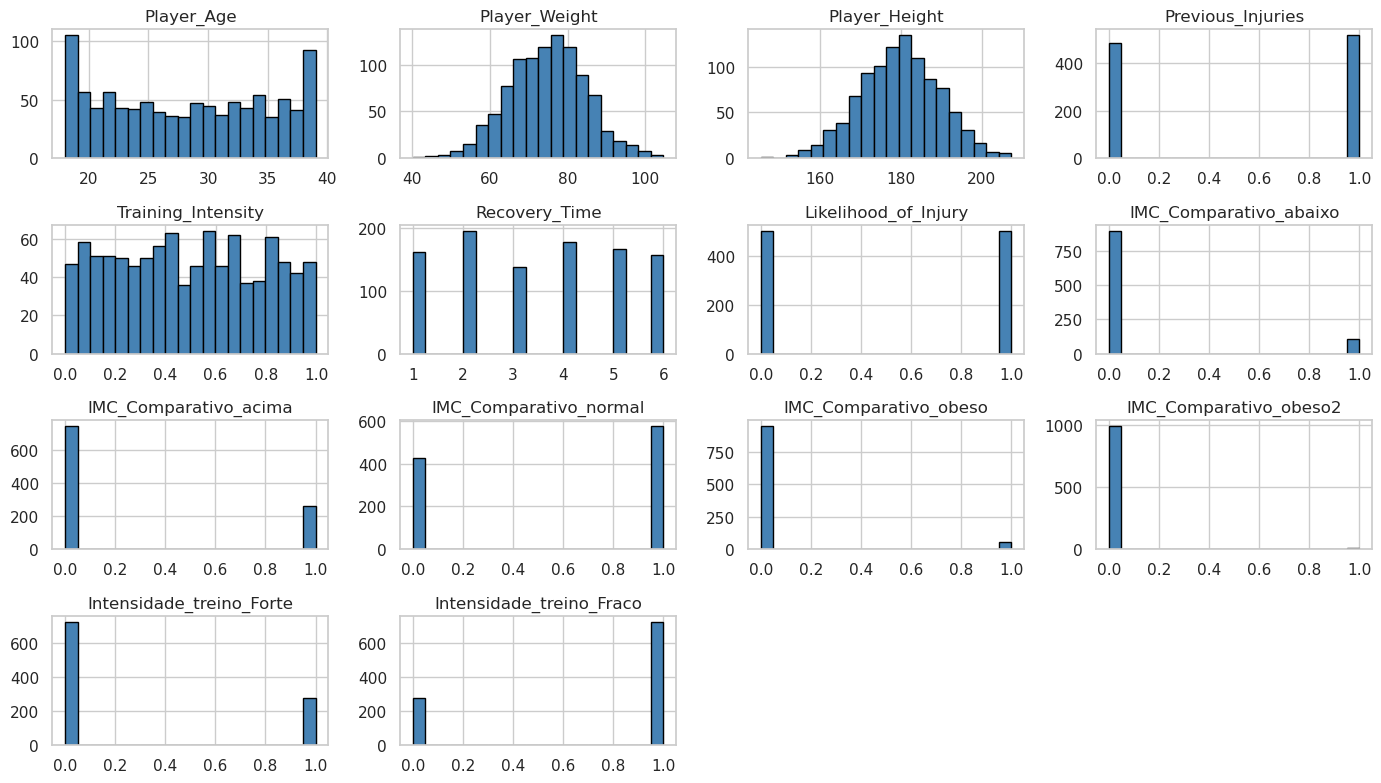

In [6]:
df.hist(bins=20, figsize=(14, 8), color='steelblue', edgecolor='black')
plt.tight_layout()
plt.show()


### Correlação entre variáveis

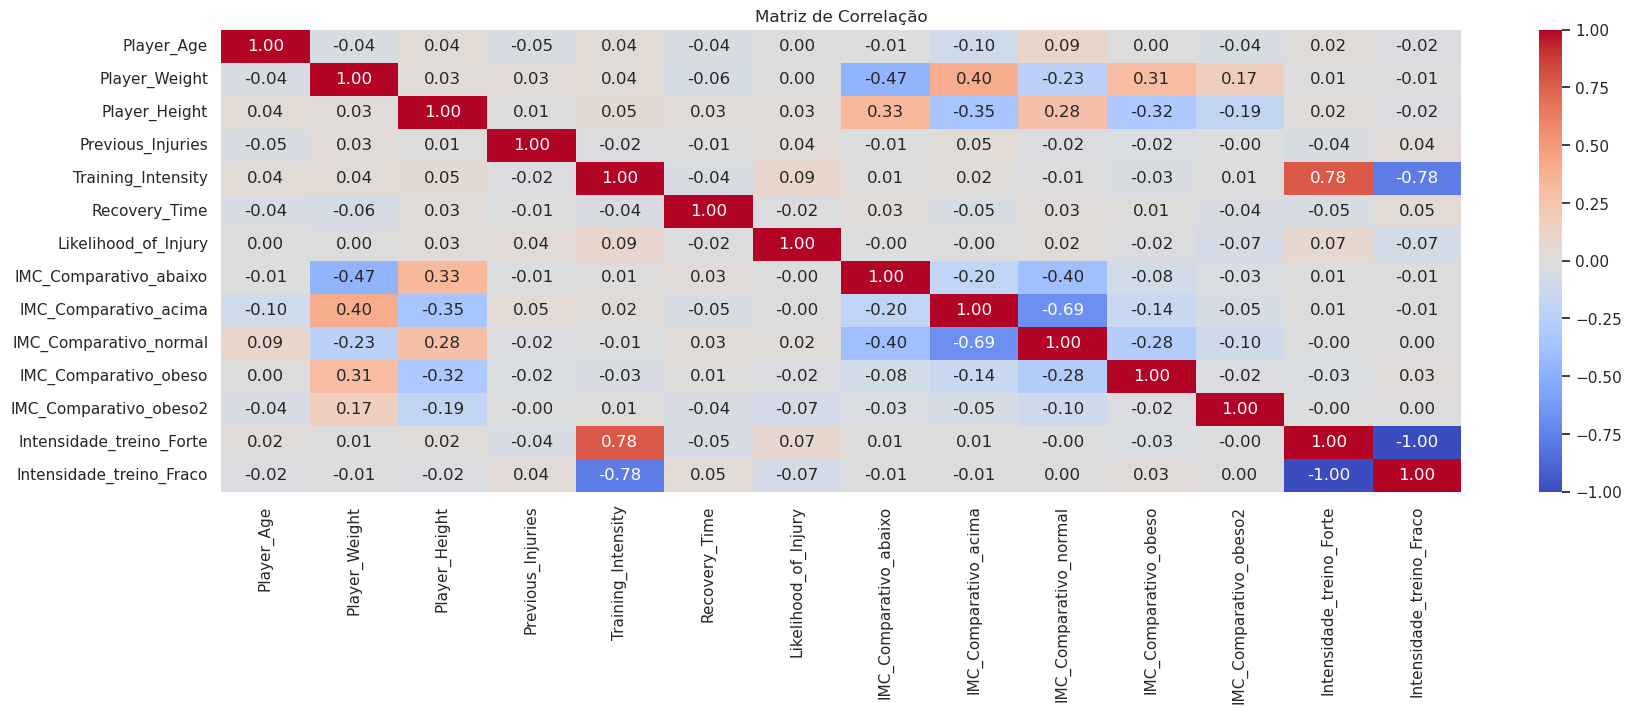

In [7]:
plt.figure(figsize=(20, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()


### Comparação entre jogadores lesionados e não lesionados

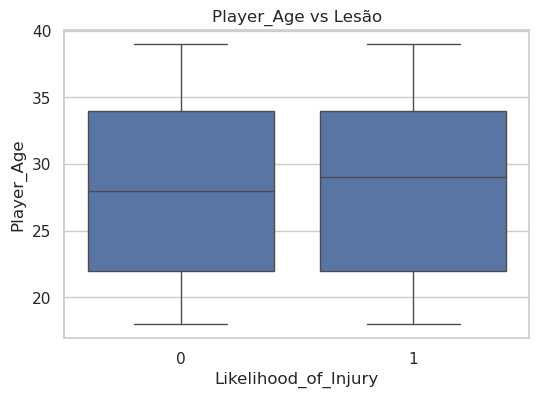

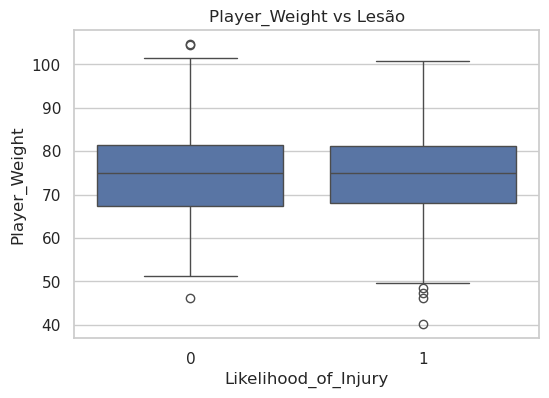

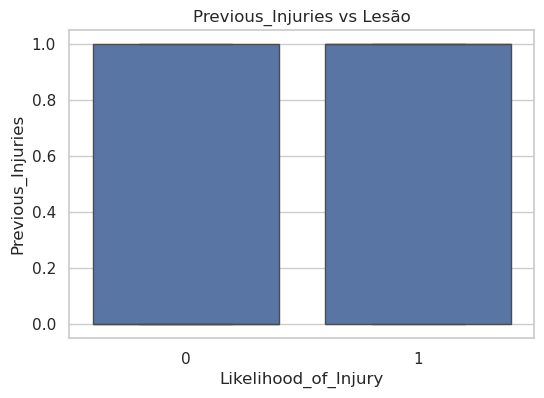

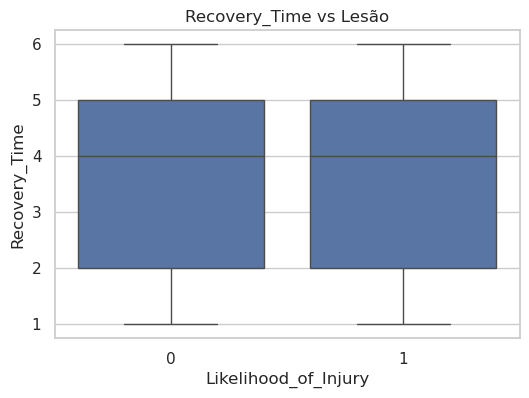

In [8]:
features = ['Player_Age', 'Player_Weight', 'Previous_Injuries', 'Recovery_Time']
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Likelihood_of_Injury', y=feature, data=df)
    plt.title(f'{feature} vs Lesão')
    plt.show()


## Pré-processamento dos Dados

In [9]:
X = df.drop("Likelihood_of_Injury", axis=1)
y = df["Likelihood_of_Injury"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


### Distribuição da Idade dos Jogadores

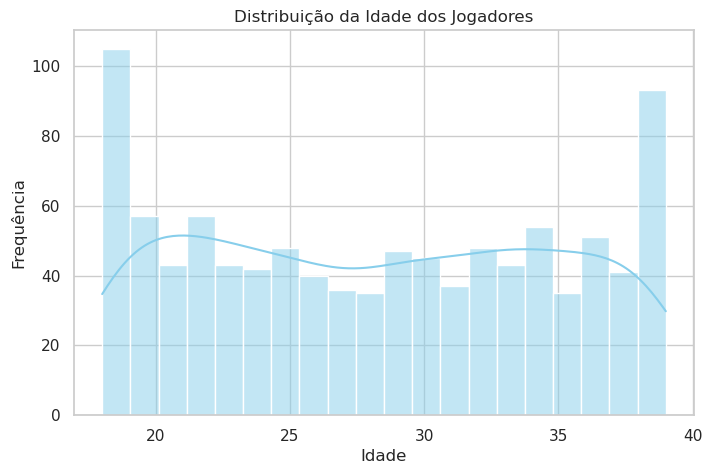

In [10]:
plt.figure(figsize=(8,5))
sns.histplot(df['Player_Age'], bins=20, kde=True, color='skyblue')
plt.title("Distribuição da Idade dos Jogadores")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()


###  Relação entre Peso e Altura dos Atletas

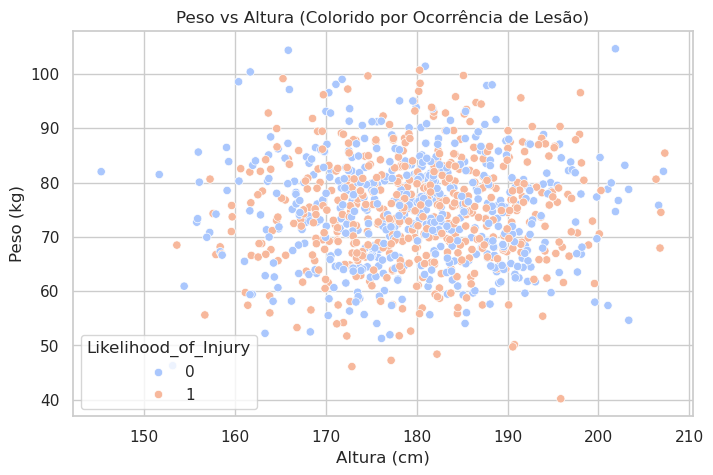

In [11]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Player_Height', y='Player_Weight', hue='Likelihood_of_Injury', palette='coolwarm')
plt.title("Peso vs Altura (Colorido por Ocorrência de Lesão)")
plt.xlabel("Altura (cm)")
plt.ylabel("Peso (kg)")
plt.show()


### Tempo de Recuperação vs Intensidade de Treino

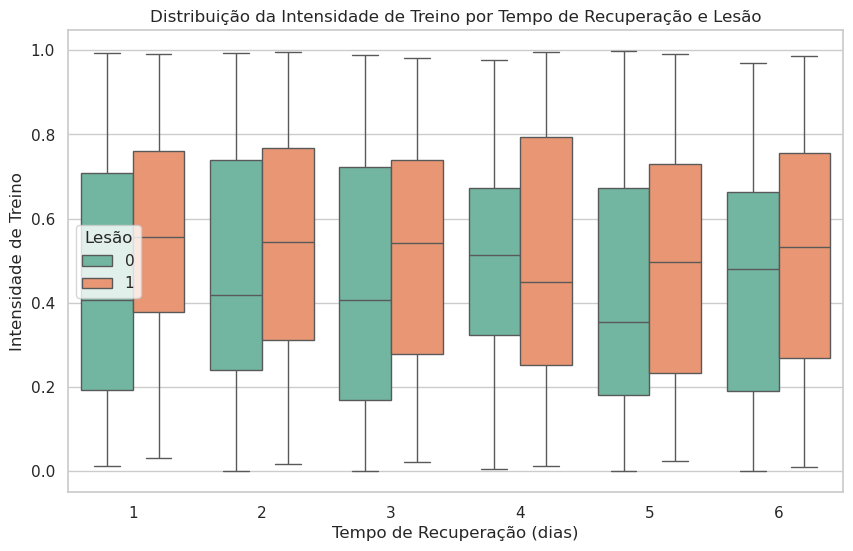

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Recovery_Time', y='Training_Intensity', hue='Likelihood_of_Injury', data=df, palette='Set2')
plt.title("Distribuição da Intensidade de Treino por Tempo de Recuperação e Lesão")
plt.xlabel("Tempo de Recuperação (dias)")
plt.ylabel("Intensidade de Treino")
plt.legend(title="Lesão")
plt.show()

## Modelagem Preditiva

### Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf))


Acurácia: 0.6
Matriz de Confusão:
 [[28 13]
 [27 32]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.51      0.68      0.58        41
           1       0.71      0.54      0.62        59

    accuracy                           0.60       100
   macro avg       0.61      0.61      0.60       100
weighted avg       0.63      0.60      0.60       100



### Regressão Logística

In [14]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred_lr))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_lr))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_lr))


Acurácia: 0.57
Matriz de Confusão:
 [[33  8]
 [35 24]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.49      0.80      0.61        41
           1       0.75      0.41      0.53        59

    accuracy                           0.57       100
   macro avg       0.62      0.61      0.57       100
weighted avg       0.64      0.57      0.56       100



### NuSVC

In [15]:
nu = NuSVC(probability=True)
nu.fit(X_train, y_train)
y_pred_nu = nu.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred_nu))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_nu))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_nu))

Acurácia: 0.61
Matriz de Confusão:
 [[17 24]
 [15 44]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.53      0.41      0.47        41
           1       0.65      0.75      0.69        59

    accuracy                           0.61       100
   macro avg       0.59      0.58      0.58       100
weighted avg       0.60      0.61      0.60       100



### Arvore de Decisão

In [16]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred_dt))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_dt))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_dt))

Acurácia: 0.63
Matriz de Confusão:
 [[26 15]
 [22 37]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.54      0.63      0.58        41
           1       0.71      0.63      0.67        59

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.64      0.63      0.63       100



## Conclusões

Com base na análise dos dados e nos modelos aplicados, podemos destacar os seguintes pontos:

- O desempenho dos modelos foi baixo, tendo uma acurácia máxima de **0.63** na **Arvore de Decisão**.

- A **matriz de confusão** no entanto, mostra que dois modelos em particular, o **NuSVC e a Floresta Aleatória** tiveram taxas de **falsos positivos** e **falsos negativos**, respectivamente, muito baixos, indicando sua possibilidade de uso como ferramenta de **auxilio a um profissional** e eventual melhora com a introdução de **mais dados**.

Para melhorar a performance preditiva dos modelos e a utilidade prática da solução, recomenda-se:

- **Coleta de Dados Mais Ricos**:
  - Incluir dados temporais e de séries históricas de desempenho;
  - Adicionar variáveis fisiológicas (frequência cardíaca, fadiga, horas de sono, etc.);
  - Inserir dados contextuais como clima, carga de jogos, posição em campo.